In [44]:
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt

import theano
import theano.tensor as tt
from theano.tensor import fft

# convert from arcseconds to radians
arcsec = np.pi / (180.0 * 3600) # [radians]  = 1/206265 radian/arcsec

# PyMC3 in the Fourier Plane

Let's take a gander at implementing a PyMC3 model to sample a visibility model. 

$$
    I(\alpha, \delta |\, \boldsymbol{\beta}) = a \exp \left [ - \left \{  \frac{(\alpha^\prime - \delta_\alpha)^2}{2 \sigma_\alpha^2} + \frac{(\delta^\prime - \delta_\delta)^2}{2 \sigma_\delta^2} \right \} \right ]
$$

then the model visibility function (via Fourier transform pairs) is

$$
    V(u, v |\, \boldsymbol{\beta}) = 2 \pi a \sigma_\alpha \sigma_\delta \exp \left [ -2 \pi^2 (\sigma_\alpha^2 u^{\prime 2} + \sigma_\delta^2 v^{\prime 2}) - 2 \pi i (\delta_\alpha u^\prime + \delta_\alpha v^\prime)\right ].
$$

Let's implement this sky plane model 

In [2]:
def sky_plane(alpha, dec, a=1, delta_alpha=0.0, delta_dec=0.0, sigma_alpha=1.0*arcsec, 
              sigma_delta=1.0*arcsec, Omega=0.0):
    '''
    a : amplitude
    delta_alpha : offset (in radians)
    delta_dec : offset (in radians)
    sigma_alpha : width (in radians)
    sigma_dec : width (in radians)
    Omega : position angle of ascending node (in degrees east of north)
    '''
    
    return a * np.exp(-( (alpha - delta_alpha)**2/(2 * sigma_alpha**2) + \
                        (dec - delta_dec)**2/(2 * sigma_delta**2)))

In [45]:
def fftspace(width, N):
    '''Oftentimes it is necessary to get a symmetric coordinate array that spans ``N``
     elements from `-width` to `+width`, but makes sure that the middle point lands
     on ``0``. The indices go from ``0`` to ``N -1.``
     `linspace` returns  the end points inclusive, wheras we want to leave out the
     right endpoint, because we are sampling the function in a cyclic manner.'''

    assert N % 2 == 0, "N must be even."

    dx = width * 2.0 / N
    xx = np.empty(N, np.float)
    for i in range(N):
        xx[i] = -width + i * dx
    
    return xx

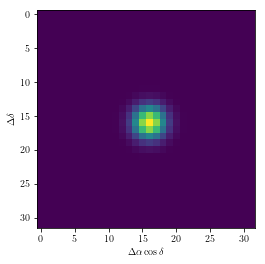

In [46]:
# Let's plot this up and see what it looks like 

N_alpha = 32 
N_dec = 32 
img_radius = 10.0 * arcsec


# full span of the image
ra = fftspace(img_radius, N_alpha) # [arcsec]
dec = fftspace(img_radius, N_dec) # [arcsec]

# fill out an image 
img = np.empty((N_dec, N_alpha), np.float)

for i,delta in enumerate(dec):
    for j,alpha in enumerate(ra):
        img[i,j] = sky_plane(alpha, delta)

plt.imshow(img, origin="upper", interpolation="none", aspect="equal")
plt.xlabel(r"$\Delta \alpha \cos \delta$");
plt.ylabel(r"$\Delta \delta$");

Now, let's FFT this to get a visibility domain version. First, we'll need to `fftshift` everything so we don't get phase-offsets. 

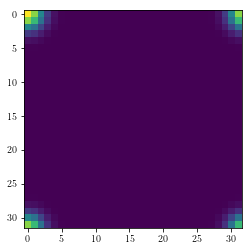

In [47]:
plt.imshow(np.fft.fftshift(img), origin="upper", interpolation="none", aspect="equal");

In [48]:
vis = np.fft.fft2(np.fft.fftshift(img))

In [ ]:
# fixed quantities that we can pre-calculate before the Theano part 
# create a fixed image plane grid of ras, decs that properly oversamples your beam
# these should already be fftshifted
XX, YY = np.meshgrid(np.fft.fftshift(ra), np.fft.fftshift(dec))

# calculate the convolution/interpolation matrix using the 
# output coordinates of the FFT (calculated from alpha, dalpha, delta, ddelta) 
# and the (u, v) locations of the dataset
# this matrix will be sparse and fixed throughout the process, so we can pre-calculate it
# using regular numpy 
# assume we'll have an N_vis length vector of data (u,v) positions 
# and a N_model length raveled vector of model visibilites, corresponding to (u, v) positions.

In [63]:
# Implement the full sky-to-visibility model in Theano

# I think we want the grid of alphas for evaluation to be a shared variable


# create input grid as a shared variable
# NOTE that these must be `fftshifted` already.
# add an extra dimension for the later packing into the rfft
alpha = theano.shared(XX[np.newaxis,:])
dalpha = abs(alpha[0,0,1] - alpha[0,0,0])
delta = theano.shared(YY[np.newaxis,:])
ddelta = abs(delta[0,1,0] - delta[0,0,0])

# a : amplitude
# delta_alpha : offset (in radians)
# delta_delta : offset (in radians)
# sigma_alpha : width (in radians)
# sigma_delta : width (in radians)

# calculate the sky-plane model
a = tt.scalar("a")
delta_alpha = tt.scalar("delta_alpha")
delta_delta = tt.scalar("delta_delta")
sigma_alpha = tt.scalar("sigma_alpha")
sigma_delta = tt.scalar("sigma_delta")

# Calculate the sky-plane model
# since the input coordinates were already shifted, then this is too
I = a * tt.exp(-(alpha - delta_alpha)**2/(2 * sigma_alpha**2) - (delta - delta_delta)**2/(2 * sigma_delta**2))
# I shape should be (1, N_dec, N_alpha)

# TODO: taper the image with the gridding correction function

# I_func = theano.function([a, delta_alpha, delta_delta, sigma_alpha, sigma_delta], I)

rfft = dalpha * ddelta * fft.rfft(I, norm=None)

# rshape = tt.shape(rfft)
# fshape = theano.function([a, delta_alpha, delta_delta, sigma_alpha, sigma_delta], rshape)
# shape (1, N_alpha, N_dec/2 + 1, 2)

fvis = theano.function([a, delta_alpha, delta_delta, sigma_alpha, sigma_delta], rfft)

# take the real and imag parts separately
# ravel them to a giant column 


# write a sparse matrix multiply

In [57]:
intensity = I_func(1, 0.0, 0.0, 1.0*arcsec, 1.0*arcsec)

In [64]:
tvis = fvis(1, 0.0, 0.0, 1.0*arcsec, 1.0*arcsec)

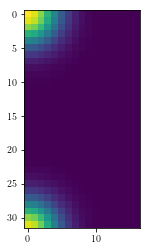

In [67]:
plt.imshow(tvis[0, :, :, 0])

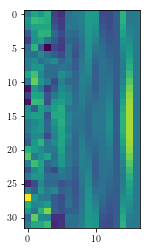

In [68]:
plt.imshow(tvis[0, :, :, 1])

## Interpolation

Set up the gridding convolution functions required for interpolating this grid to the actual UV data points. 

Since we have the RFFT output collapsed along one axis, we could either expand the array into the full $-u,u$, $-v, v$ directions, or we could instead alter the convolution operation to just read the appropriate mirrored side. 

The latter might be kind of confusing, but I'm more inclined to try it.